## Bank-Marketing-System

Dataset: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, mutual_info_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### Read Dataset

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
numerical = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [7]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

In [8]:
binary_values = {
    'no': 0,
    'yes': 1
}
df["y"] = df["y"].map(binary_values)

In [9]:
df.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [10]:
df.shape

(41188, 21)

In [11]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [12]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [13]:
df.y.value_counts(normalize=False)

0    36548
1     4640
Name: y, dtype: int64

In [14]:
for col in df.columns:
    print("--- " + col + " ---")
    print("Number Of Unique Values: " + str(df[col].nunique()))
    print(df[col].unique()[:10])
    print()

--- age ---
Number Of Unique Values: 78
[56 57 37 40 45 59 41 24 25 29]

--- job ---
Number Of Unique Values: 12
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown']

--- marital ---
Number Of Unique Values: 4
['married' 'single' 'divorced' 'unknown']

--- education ---
Number Of Unique Values: 8
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

--- default ---
Number Of Unique Values: 3
['no' 'unknown' 'yes']

--- housing ---
Number Of Unique Values: 3
['no' 'yes' 'unknown']

--- loan ---
Number Of Unique Values: 3
['no' 'yes' 'unknown']

--- contact ---
Number Of Unique Values: 2
['telephone' 'cellular']

--- month ---
Number Of Unique Values: 10
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

--- day_of_week ---
Number Of Unique Values: 5
['mon' 'tue' 'wed' 'thu' 'fri']

--- duration ---
Number Of Unique Values: 1544
[261 149 226 151

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>],
       [<AxesSubplot:title={'center':'pdays'}>,
        <AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'emp.var.rate'}>],
       [<AxesSubplot:title={'center':'cons.price.idx'}>,
        <AxesSubplot:title={'center':'cons.conf.idx'}>,
        <AxesSubplot:title={'center':'euribor3m'}>],
       [<AxesSubplot:title={'center':'nr.employed'}>,
        <AxesSubplot:title={'center':'y'}>, <AxesSubplot:>]], dtype=object)

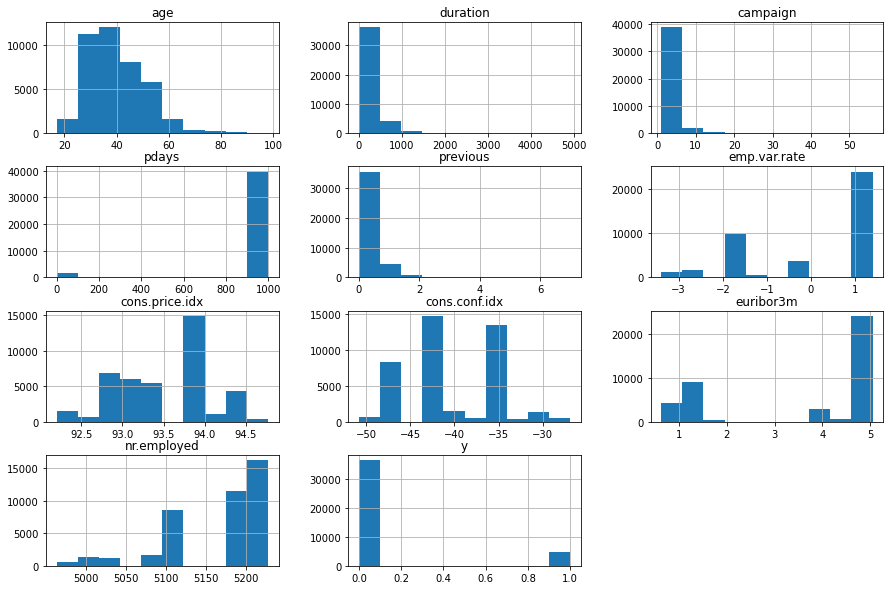

In [15]:
df.hist(figsize=(15,10))

#### feature importance analysis

In [17]:
corr_matrix = df.corr()
corr_matrix

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


<AxesSubplot:>

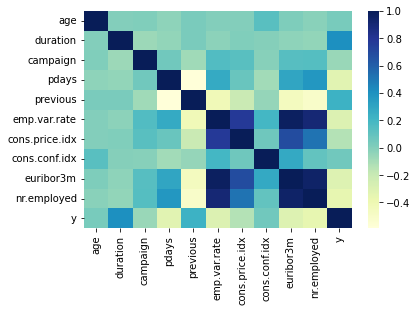

In [18]:
sns.heatmap(corr_matrix, cmap="YlGnBu")

In [19]:
df[numerical].corrwith(df.y).abs().sort_values(ascending=False)

duration          0.405274
nr.employed       0.354678
pdays             0.324914
euribor3m         0.307771
emp.var.rate      0.298334
previous          0.230181
cons.price.idx    0.136211
campaign          0.066357
cons.conf.idx     0.054878
age               0.030399
dtype: float64

#### Mutual information

In [21]:
def mutual_info_target_score(series):
    return mutual_info_score(series, df.y)

In [22]:
mi = df[categorical].apply(mutual_info_target_score)
mi.sort_values(ascending=False)

y              0.352029
poutcome       0.030384
month          0.026407
contact        0.011646
job            0.009859
default        0.005774
education      0.002390
marital        0.001434
day_of_week    0.000322
housing        0.000069
loan           0.000013
dtype: float64

In [23]:
df_cpoy = df.copy()
del df_cpoy['loan']
del df_cpoy['housing']
del df_cpoy['day_of_week']
del df_cpoy['marital']
del df_cpoy['education']
del df_cpoy['default']

### Data Preprocessing

#### Split Dataset into Train, Validation and Test Data

In [24]:
df_full_train, df_test = train_test_split(df_cpoy, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

#### Encode categorical features (Apply One Hot Encoding)

In [26]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient="records")
X_val = dv.fit_transform(val_dict)

test_dict = df_test.to_dict(orient="records")
X_test = dv.fit_transform(test_dict)

In [27]:
dv.get_feature_names()

['age',
 'campaign',
 'cons.conf.idx',
 'cons.price.idx',
 'contact=cellular',
 'contact=telephone',
 'duration',
 'emp.var.rate',
 'euribor3m',
 'job=admin.',
 'job=blue-collar',
 'job=entrepreneur',
 'job=housemaid',
 'job=management',
 'job=retired',
 'job=self-employed',
 'job=services',
 'job=student',
 'job=technician',
 'job=unemployed',
 'job=unknown',
 'month=apr',
 'month=aug',
 'month=dec',
 'month=jul',
 'month=jun',
 'month=mar',
 'month=may',
 'month=nov',
 'month=oct',
 'month=sep',
 'nr.employed',
 'pdays',
 'poutcome=failure',
 'poutcome=nonexistent',
 'poutcome=success',
 'previous']

## Model training
Trained multiple models (linear and tree-based)

### LogisticRegression Model

#### Base Model

In [29]:
lr_base = LogisticRegression(solver='liblinear', C=1.0)
lr_base.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [30]:
print(f"Model intercept: {lr_base.intercept_[0].round(5)}")
print(f"Model coefficients: {dict(zip(dv.get_feature_names(), lr_base.coef_[0].round(5)))}")

Model intercept: 0.00337
Model coefficients: {'age': 0.00116, 'campaign': -0.05074, 'cons.conf.idx': 0.04621, 'cons.price.idx': 0.31781, 'contact=cellular': 0.07289, 'contact=telephone': -0.06952, 'duration': 0.00472, 'emp.var.rate': -0.26628, 'euribor3m': -0.28353, 'job=admin.': 0.03863, 'job=blue-collar': -0.07327, 'job=entrepreneur': -0.00814, 'job=housemaid': -0.00098, 'job=management': -0.00337, 'job=retired': 0.02423, 'job=self-employed': 0.00043, 'job=services': -0.01445, 'job=student': 0.02483, 'job=technician': 0.00838, 'job=unemployed': 0.00633, 'job=unknown': 0.00075, 'month=apr': 0.01502, 'month=aug': 0.02451, 'month=dec': 0.00437, 'month=jul': 0.02843, 'month=jun': 0.03598, 'month=mar': 0.05274, 'month=may': -0.17235, 'month=nov': -0.01141, 'month=oct': 0.01724, 'month=sep': 0.00882, 'nr.employed': -0.00574, 'pdays': -0.00148, 'poutcome=failure': -0.0349, 'poutcome=nonexistent': 0.02842, 'poutcome=success': 0.00985, 'previous': -0.01572}


In [31]:
y_pred_bin = lr_base.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_bin)

0.9233806992435085

#### Tune Hyperparameters using GridSearchCV

In [32]:
# Define the parameter grid
param_grid = {
    "C": np.linspace(-3,3,13)
}

# Define the grid search model
lr = LogisticRegression(random_state=1)
search_lr = GridSearchCV(
    estimator=lr, 
    param_grid=param_grid, 
    n_jobs=-1
)
# By default it uses 5 fold

# Train the grid search model with training dataset
search_lr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
        2.5,  3. ])})

In [33]:
# Get the tuned hyperparameters from the grid search model
print(f"Best parameter (CV Score = {search_lr.best_score_.round(3)}):")
print(search_lr.best_params_)

Best parameter (CV Score = 0.911):
{'C': 2.0}


In [34]:
lr_tuned = LogisticRegression(solver='liblinear', C=2.0)
lr_tuned.fit(X_train, y_train)

LogisticRegression(C=2.0, solver='liblinear')

In [35]:
print(f"Model intercept: {lr_tuned.intercept_[0].round(5)}")
print(f"Model coefficients: {dict(zip(dv.get_feature_names(), lr_tuned.coef_[0].round(5)))}")

Model intercept: 0.00328
Model coefficients: {'age': 0.00088, 'campaign': -0.05596, 'cons.conf.idx': 0.02595, 'cons.price.idx': 0.38018, 'contact=cellular': 0.18699, 'contact=telephone': -0.18371, 'duration': 0.00464, 'emp.var.rate': -0.32054, 'euribor3m': -0.13727, 'job=admin.': 0.10543, 'job=blue-collar': -0.27663, 'job=entrepreneur': -0.04588, 'job=housemaid': -0.00719, 'job=management': -0.01333, 'job=retired': 0.11699, 'job=self-employed': -0.00069, 'job=services': -0.05949, 'job=student': 0.11943, 'job=technician': 0.03127, 'job=unemployed': 0.02719, 'job=unknown': 0.0062, 'month=apr': -0.01882, 'month=aug': 0.16878, 'month=dec': 0.01185, 'month=jul': 0.14573, 'month=jun': 0.18161, 'month=mar': 0.32412, 'month=may': -0.71019, 'month=nov': -0.09221, 'month=oct': 0.0248, 'month=sep': -0.0324, 'nr.employed': -0.00708, 'pdays': -0.00162, 'poutcome=failure': -0.19968, 'poutcome=nonexistent': 0.15541, 'poutcome=success': 0.04754, 'previous': -0.12923}


In [36]:
# Predict using validation dataset
y_pred_bin = lr_tuned.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_bin)

0.9323286210824546

### Decision Tree Model

#### Base Model

In [37]:
dt_base = DecisionTreeClassifier(random_state=1)
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [38]:
y_pred = dt_base.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7275745538452552

#### Tune Hyperparameters using GridSearchCV

In [39]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter":["best", "random"],
    "max_depth": [None, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_features":[None, 3, 5, 7, 9, 11],
    "min_samples_leaf": [2, 3, 5, 7, 9, 11],
    "min_samples_split": [2, 3, 5, 7, 9, 11, 13, 15]
}

In [40]:
# Define the grid search model
dt = DecisionTreeClassifier(random_state=1)
search_dt = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    n_jobs=-1
)

# Train the grid search model with training dataset
search_dt.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [None, 3, 5, 7, 9, 11],
                         'min_samples_leaf': [2, 3, 5, 7, 9, 11],
                         'min_samples_split': [2, 3, 5, 7, 9, 11, 13, 15],
                         'splitter': ['best', 'random']})

In [52]:
# Get the tuned hyperparameters from the grid search model
print(f"Best parameter (CV Score = {search_dt.best_score_.round(3)}):")
print(search_dt.best_params_)

Best parameter (CV Score = 0.915):
{'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 11, 'min_samples_split': 2, 'splitter': 'best'}


In [41]:
# Train the model again with tuned parameters
dt_tuned = DecisionTreeClassifier(
    criterion="entropy", 
    max_depth=5, 
    max_features=None, 
    min_samples_leaf=11, 
    min_samples_split=2, 
    splitter="best", 
    random_state=1
)
dt_tuned.fit(X_train, y_train)

# Predit using validation dataset
y_pred_val = dt_tuned.predict_proba(X_val)[:, 1]
result = (y_pred_val >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred_val).round(3)}")

Validation dataset AUC: 0.931


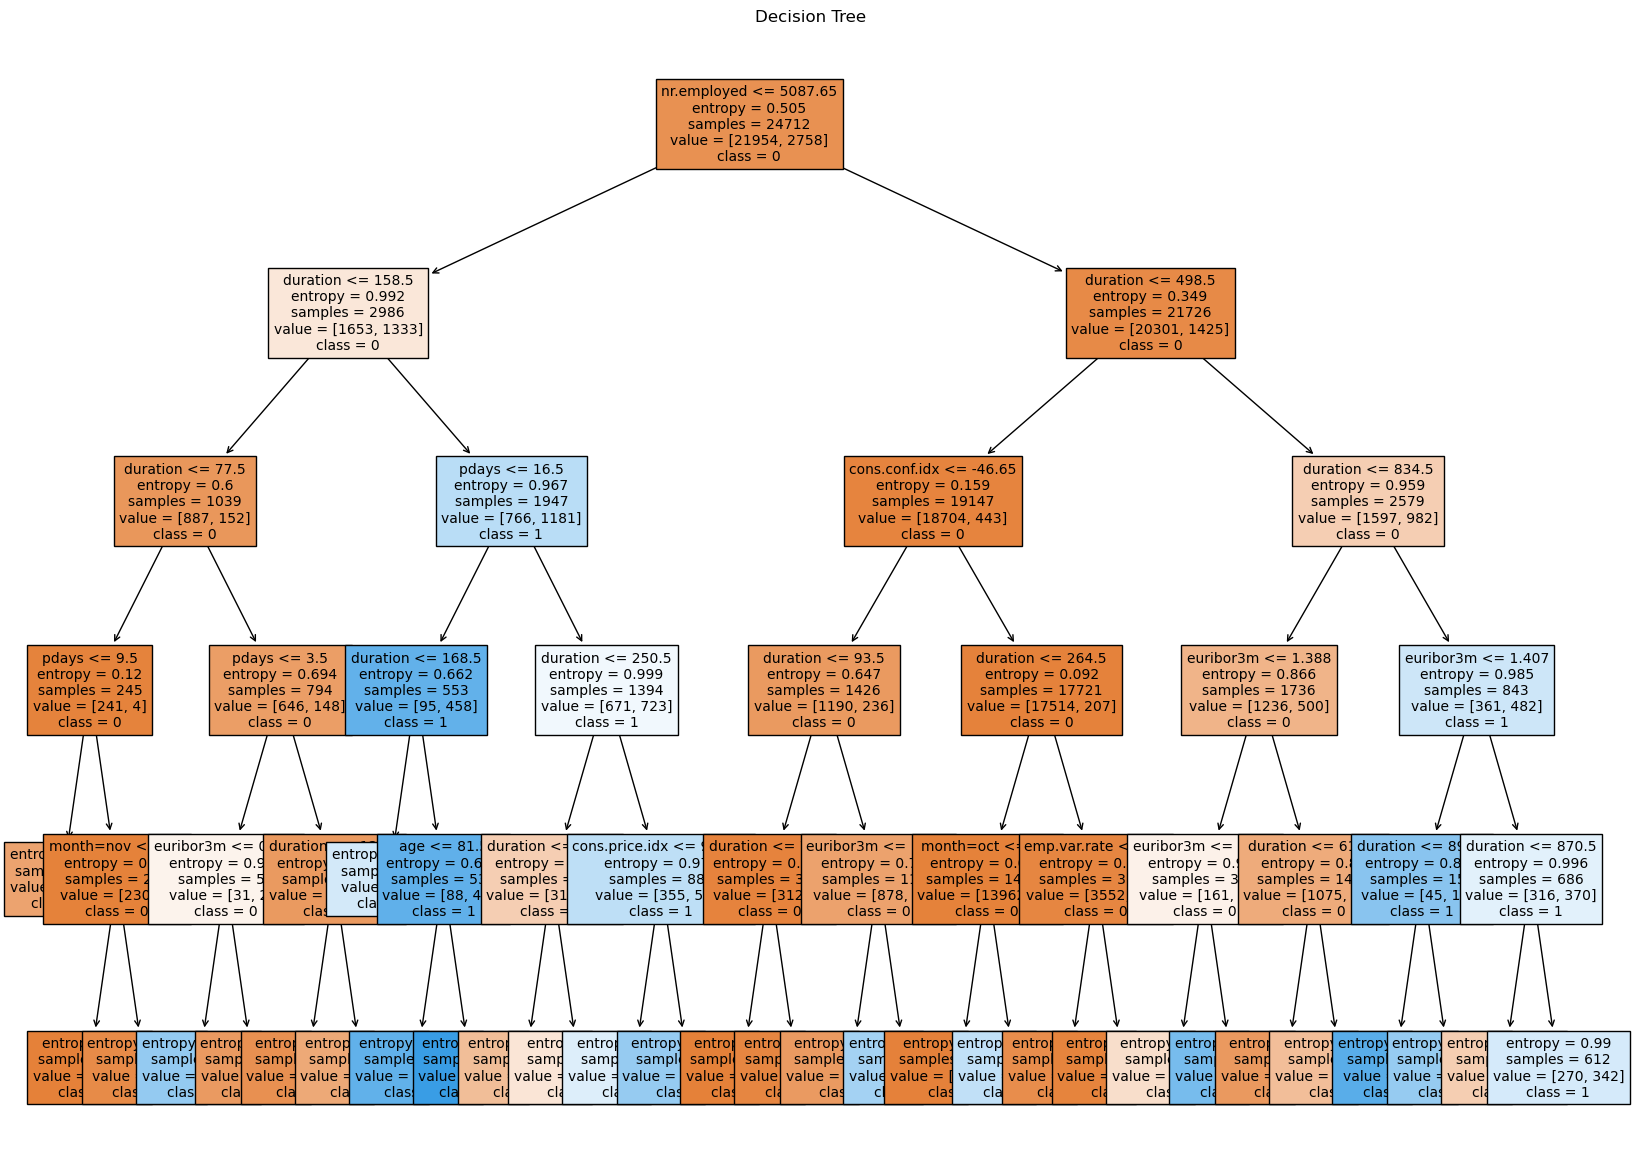

In [42]:
# Plot the final decision tree
feature_names = list(dv.get_feature_names())
class_names = list(map(str, df["y"].unique()))

plt.figure(figsize=(20,15), dpi=100)
plot_tree(dt_tuned, feature_names=feature_names, class_names=class_names, filled=True, fontsize=10)
plt.title("Decision Tree")
plt.show()

In [43]:
importances = dt_tuned.feature_importances_

orders = dict(zip(dv.get_feature_names(), importances))

sort_orders = sorted(orders.items(), key=lambda x: x[1], reverse=True)

for i in sort_orders:
	print(i[0], ":", i[1])

duration : 0.5161806835229934
nr.employed : 0.3217058656951673
cons.conf.idx : 0.08191556249358095
pdays : 0.025737945871546365
euribor3m : 0.023911985901059727
month=oct : 0.017450089653467078
emp.var.rate : 0.009882632465887584
cons.price.idx : 0.0018731177555698128
month=nov : 0.000684474096794501
age : 0.0006576425439333304
campaign : 0.0
contact=cellular : 0.0
contact=telephone : 0.0
job=admin. : 0.0
job=blue-collar : 0.0
job=entrepreneur : 0.0
job=housemaid : 0.0
job=management : 0.0
job=retired : 0.0
job=self-employed : 0.0
job=services : 0.0
job=student : 0.0
job=technician : 0.0
job=unemployed : 0.0
job=unknown : 0.0
month=apr : 0.0
month=aug : 0.0
month=dec : 0.0
month=jul : 0.0
month=jun : 0.0
month=mar : 0.0
month=may : 0.0
month=sep : 0.0
poutcome=failure : 0.0
poutcome=nonexistent : 0.0
poutcome=success : 0.0
previous : 0.0


### XGBoost Model

#### Base Model

In [46]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

watchlist = [(dtrain, "train"), (dval, "val")]

In [47]:
# Train the model with training dataset using default parameters
xgb_params = {
    "objective": "binary:logistic",
    "seed": 1
}
xgb_model_base = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

[17:14:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.49287	val-logloss:0.49727
[5]	train-logloss:0.21395	val-logloss:0.22953
[10]	train-logloss:0.16480	val-logloss:0.18686
[15]	train-logloss:0.15251	val-logloss:0.17801
[20]	train-logloss:0.14681	val-logloss:0.17674
[25]	train-logloss:0.14201	val-logloss:0.17690
[30]	train-logloss:0.13805	val-logloss:0.17663
[35]	train-logloss:0.13491	val-logloss:0.17642
[40]	train-logloss:0.13250	val-logloss:0.17703
[45]	train-logloss:0.12949	val-logloss:0.17678
[50]	train-logloss:0.12573	val-logloss:0.17747
[55]	train-logloss:0.12363	val-logloss:0.17744
[60]	train-logloss:0.12148	val-logloss:0.17792
[65]	train-logloss:0.11935	val-logloss:0.17848
[70]	train-logloss:0.11684	val-log

In [48]:
y_pred = xgb_model_base.predict(dval)
result = (y_pred >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

Validation dataset AUC: 0.947


#### Tune Hyperparameters

In [43]:
# Define the parameter grid
param_grid = {
    "learning_rate": np.arange(0, 1, 0.03),
    'n_estimators': [50, 100, 200, 300],
    "objective": ["binary:logistic"],
    "seed": [1]
}

In [44]:
# Define the grid search model
xgb_model = xgb.XGBClassifier(random_state=1, n_jobs=-1, use_label_encoder=False)
search_xgb = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    n_jobs=-1
)

# Train the grid search model with training dataset
search_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(n_jobs=-1, random_state=1,
                                     use_label_encoder=False),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
       0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
       0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
       0.99]),
                         'n_estimators': [50, 100, 200, 300],
                         'objective': ['binary:logistic'], 'seed': [1]})

In [45]:
# Get the tuned hyperparameters from the grid search model
print(f"Best parameter (CV Score = {search_xgb.best_score_.round(3)}):")
print(search_xgb.best_params_)

Best parameter (CV Score = 0.918):
{'learning_rate': 0.21, 'n_estimators': 100, 'objective': 'binary:logistic', 'seed': 1}


In [49]:
# Train the model with training dataset using default parameters
xgb_params = {
    "eta": 0.21,
    "objective": "binary:logistic",
    "seed": 1
}
xgb_model_tuned = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

[17:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.54576	val-logloss:0.54887
[5]	train-logloss:0.26398	val-logloss:0.27641
[10]	train-logloss:0.18986	val-logloss:0.20754
[15]	train-logloss:0.16484	val-logloss:0.18636
[20]	train-logloss:0.15509	val-logloss:0.17928
[25]	train-logloss:0.15047	val-logloss:0.17719
[30]	train-logloss:0.14744	val-logloss:0.17672
[35]	train-logloss:0.14527	val-logloss:0.17665
[40]	train-logloss:0.14147	val-logloss:0.17641
[45]	train-logloss:0.13898	val-logloss:0.17683
[50]	train-logloss:0.13676	val-logloss:0.17642
[55]	train-logloss:0.13496	val-logloss:0.17662
[60]	train-logloss:0.13331	val-logloss:0.17686
[65]	train-logloss:0.13060	val-logloss:0.17655
[70]	train-logloss:0.12801	val-log

In [50]:
# Predict using validation dataset
y_pred_val = xgb_model_tuned.predict(dval)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred_val).round(3)}")

Validation dataset AUC: 0.949


## Choosing the Best Model

#### Best Model: XGBoost

#### Predict on Test Dataset

In [51]:
# Train the model with training dataset using default parameters
xgb_params = {
    "eta": 0.21,
    "objective": "binary:logistic",
    "seed": 1
}
xgb_model_final = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

# Predict using test dataset
y_pred = xgb_model_final.predict(dtest)
print(f"Test dataset AUC: {roc_auc_score(y_test, y_pred).round(3)}")

[17:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.54576	val-logloss:0.54887
[5]	train-logloss:0.26398	val-logloss:0.27641
[10]	train-logloss:0.18986	val-logloss:0.20754
[15]	train-logloss:0.16484	val-logloss:0.18636
[20]	train-logloss:0.15509	val-logloss:0.17928
[25]	train-logloss:0.15047	val-logloss:0.17719
[30]	train-logloss:0.14744	val-logloss:0.17672
[35]	train-logloss:0.14527	val-logloss:0.17665
[40]	train-logloss:0.14147	val-logloss:0.17641
[45]	train-logloss:0.13898	val-logloss:0.17683
[50]	train-logloss:0.13676	val-logloss:0.17642
[55]	train-logloss:0.13496	val-logloss:0.17662
[60]	train-logloss:0.13331	val-logloss:0.17686
[65]	train-logloss:0.13060	val-logloss:0.17655
[70]	train-logloss:0.12801	val-log

In [59]:
%run train.py

[18:34:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC on fold 0 is 0.9477476457195496
[18:34:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC on fold 1 is 0.9517972626429043
[18:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior